# AER for HFIR Cycle 502

***
## Basic constants and functions
***

In [187]:
import numpy as np
import sympy as sym
import scipy as sc
import matplotlib.pyplot as plt
import mcstasscript as ms
import scienceplots
import time, math, os
from scipy.optimize import curve_fit
from scipy.signal import hilbert,convolve,find_peaks
from scipy.fft import fft,fftfreq,ifft
from scipy.integrate import quad,simpson
from scipy.interpolate import CubicSpline
from matplotlib.animation import FuncAnimation, PillowWriter
from itertools import islice

plt.style.use(['science', 'notebook', 'grid', 'default', 'bright'])
plot_height = 8
plot_width = plot_height*1.618

SMALL_SIZE,MEDIUM_SIZE,BIGGER_SIZE = 20,30,40
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rc('axes', titlesize=BIGGER_SIZE)    # actually gets title font size (glitch in matplotlib?)
plt.rcParams.update({'axes.grid':True})

if False: #Additions to latex preamble for matplotlib:
    plt.rc('text', usetex=True)
    plt.rc('text.latex', preamble=r'\usepackage{amsmath,amsthm,amssymb,amsfonts,braket,siunitx}')
    plt.rcParams["font.family"] = "Computer Modern Roman"
sym.init_printing()

xp = 1/np.sqrt(2)*np.array([[1],[1]]) #spin states
xm = 1/np.sqrt(2)*np.array([[1],[-1]])
yp = 1/np.sqrt(2)*np.array([[1],[1j]])
ym = 1/np.sqrt(2)*np.array([[1],[-1j]])
zp = np.array([[1],[0]])
zm = np.array([[0],[1]])

sx = np.array([[0,1],[1,0]]) #Pauli operators
sy = np.array([[0,-1j],[1j,0]])
sz = np.array([[1,0],[0,-1]])

G = -1.832471e8    #gyromagnetic ratio of neutron (rad/T/m^2)
M = 1.674927e-27    #mass of neutron (kg)
HBAR = 1.054571e-34    #plancks constant (kg m^2/s)
CL = G/(HBAR*2*np.pi)*M*1e-10    #Larmor phase constant (T^-1 m^-1 AA^-1)

In [2]:
def rebin(data,new_shape):
    """Rebins 2D data by taking average."""
    sh = new_shape[0],data.shape[0]//new_shape[0],new_shape[1],data.shape[1]//new_shape[1]
    return data.reshape(sh).mean(3).mean(1)

def get_SS_focus(harm,Ls,res,ml,a,L):
    """Returns SESANS magnetic field focuing condtion (T)."""
    return 2*np.pi*harm*Ls/(res/1e3)/(CL*lam*a*(L[1] - L[0]))

def cos(x,amp,freq,phase,shim):
    """Simple cosine with shim."""
    return amp*np.cos(x*freq + phase) + shim

def pol_sc(x,A,B,freq):
    """Linear combination of sine and cosine."""
    return A*np.cos(x*freq) + B*np.sin(x*freq)

def quad_cos(x,amp,freq,qfreq,phase,shim):
    """Cosine with quadratic frequency and shim."""
    return amp*np.cos(x*freq + x**2*qfreq + phase) + shim

def g_cos(x,amp,freq,phase,shim,mean,sigma):
    """Cosine with Gaussian envelope and shim."""
    return amp*np.exp(-(x - mean)**2/2/sigma**2)*np.cos(x*freq + phase) + shim

def quad(x,a,b,c):
    """Returns quadratic for peak fitting."""
    return a*x**2 + b*x + c

def sample_factor(x,r,ls,ld):
    """Returns tupule of sample seen by pixel x."""
    return -r/2 - (1 -ls/ld)*x, r/2 - (1 -ls/ld)*x

In [3]:
I1,I2,I3,I4,x,phi,theta,delta1,delta2 = sym.symbols('I_1,I_2,I_3,I_4,x,phi,theta,delta_1,delta_2', real=True)
L1,L2,L3,L4,a,b,lam,delta = sym.symbols('L_1,L_2,L_3,L_4,a,b,lambda,delta', real=True, positive=True)
larm = sym.symbols('c_L', real=True, negative=True)
#b=a  #idealized case

A = 5e-3 #in Tesla
B = 5e-3 #in Tesla

def MWP(a,b,I,x,phi,inv=False):
    """Field integral from MWP."""
    if inv: a = -a
    return I*(a*x + b*x*phi)

def AER(L1,L2,I1,I2,focus_SS=False):
    """Field integral with option focusing conditions."""
    result = MWP(a,b,I1,x-L1*phi,phi) + MWP(a,b,I2,x-L2*phi,phi)
    if focus_SS: result = result.subs(I2,-I1)
    return result.expand().collect([a,b]).simplify() 

def double_AER(L1,L2,L3,L4,I1,I2,I3,I4,focus_SS=False):
    """Field integral with option focusing conditions."""
    result = MWP(a,b,I1,x-L1*phi,phi) + MWP(a,b,I2,x-L2*phi,phi) + \
                MWP(a,b,I3,x-L3*phi,phi) + MWP(a,b,I4,x-L4*phi,phi)
    if focus_SS: result = result.subs([(I2,I1),(I3,-I1),(I4,-I1)])
    return result.expand().collect([a,b]).simplify() 

def SEMSANS_tilt(L1,L2,I1,I2,focus_SS=False):
    """Field integral with option focusing conditions."""
    result = MWP(a,b,I1,x*(sym.cos(theta)-phi*sym.sin(theta))-L1*phi,phi) + \
                MWP(a,b,I2,x*(sym.cos(theta)-phi*sym.sin(theta))-L2*phi,phi)
    if focus_SS: result = result.subs(I2,-I1*L1/L2)
    return result.expand().collect([a,b]).simplify() 

print('Ideal:')
display(AER(L1,L2,I1,I2,focus_SS=True))

print('First MWP off:')
display(AER(L1,L2,I1+delta1,I2))
display(AER(L1,L2,I1+delta1,I2,focus_SS=True))

print('Second MWP off:')
display(AER(L1,L2,I1,I2+delta2))
display(AER(L1,L2,I1,I2+delta2,focus_SS=True))

print('Both MWPs off:')
display(AER(L1,L2,I1+delta1,I2+delta2))
display(AER(L1,L2,I1+delta1,I2+delta2,focus_SS=True))

Ideal:


First MWP off:


Second MWP off:


Both MWPs off:


In [4]:
#display(double_AER(L1,L2,L3,L4,I1,I2,I3,I4,focus_SS=True))
"""display(SEMSANS_tilt(L1,L2,I1,I2,focus_SS=False))
display(SEMSANS_tilt(L1,L2,I1,I2,focus_SS=True))
theta = 0
display(SEMSANS_tilt(L1,L2,I1,I2,focus_SS=True))
theta = sym.pi/4
display(SEMSANS_tilt(L1,L2,I1,I2,focus_SS=True))
theta = -sym.pi/4
display(SEMSANS_tilt(L1,L2,I1,I2,focus_SS=True))"""

'display(SEMSANS_tilt(L1,L2,I1,I2,focus_SS=False))\ndisplay(SEMSANS_tilt(L1,L2,I1,I2,focus_SS=True))\ntheta = 0\ndisplay(SEMSANS_tilt(L1,L2,I1,I2,focus_SS=True))\ntheta = sym.pi/4\ndisplay(SEMSANS_tilt(L1,L2,I1,I2,focus_SS=True))\ntheta = -sym.pi/4\ndisplay(SEMSANS_tilt(L1,L2,I1,I2,focus_SS=True))'

***
## Building the beamline
***

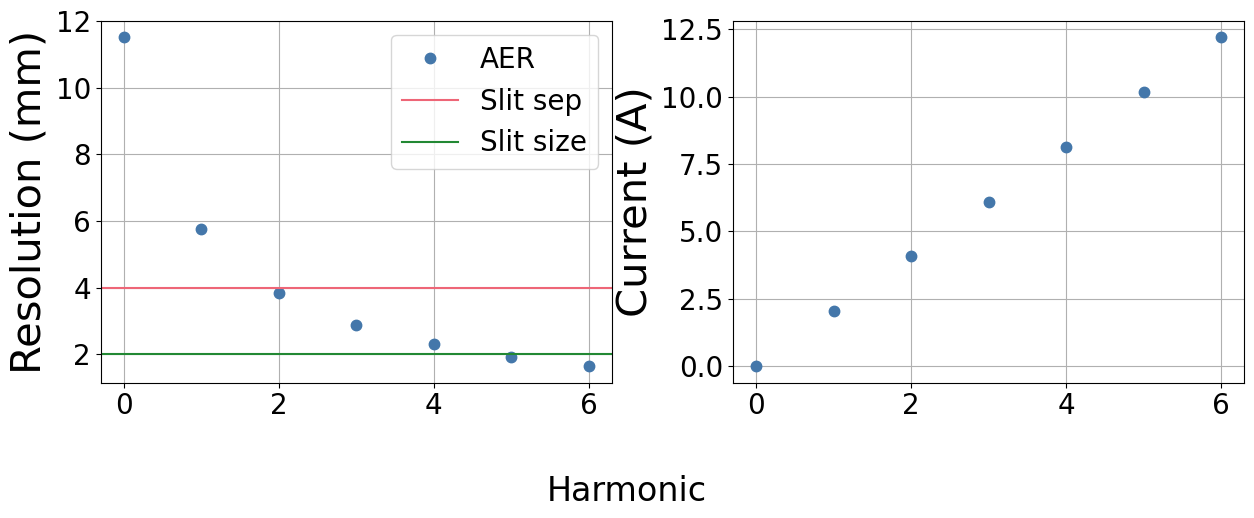

Wavelength: 5.5 p/m  0.014 (Angstroms)
Aperture diameter: 20.0 (mm)
Midpoint distances from MWP to detector: [2.9 2.5] (m)
Distance from aperture to detector: 3.3 (m)
Distance from sample to detector: 1.9 (m)
Geometric resolution: 11.515 (mm) 

MWP currents for first and last harmonic: [ 2.035 12.208] (amps)
Polarizer axis: [1.0, 0.0, 0.0] 

Detector size: [10.0, 10.0] (mm)
[x,y] bin number: [100, 100]
[x,y] bin size: [0.1, 0.1] (mm) 

Maximum divergence angle (deg): 0.26044


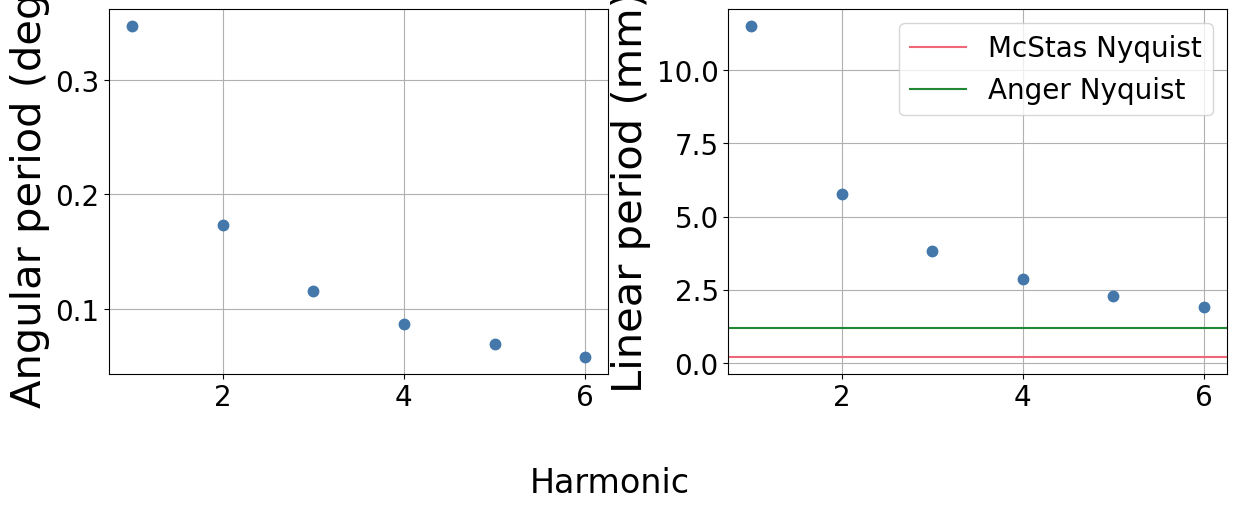

--------------------------------------------------------------------------------
double delta_lambda  = 0.01375  // Wavelength spread [AA]
int    low_count     = 0        // if true flips analyzer direction [N/A]
int    all_off       = 0        // if true turns off all MWPs [N/A]
double cur1          = 0.0      // MWP1 current [Amps]
double cur2          = -0.0     // MWP2 current [Amps]
double BCG           = 0.0      // Center guide field [Gauss]
double polx          = 1.0      // x-component of polarizer [N/A]
double poly          = 0.0      // y-component of polarizer [N/A]
double polz          = 0.0      // z-component of polarizer [N/A]
--------------------------------------------------------------------------------
COMPONENT src = Source_sam(
  dist = 3.3, // [m]
  focus_xw = 0.01, // [m]
  focus_yh = 0.01, // [m]
  lambda0 = 5.5, // [AA]
  dlambda = delta_lambda, // [AA]
  I1 = 1000000000000000.0, // [1/(cm**2*sr)]
  yheight = 0.02, // [m]
  xwidth = 0.02 // [m]
)
AT (0, 0, 0) 

In [5]:
lds = [4.,2.37,1.73,1.65]
lses = [.1,.35,.5]
aps = [10.,13.,20.]

lam = 5.5  #wavelength (AA)
dl = lam*.5/100/2
ap_width = 20. #aperature dimensions (mm)
ap_height = 20.

cg_gpa = 25.  #25 Gauss per amp for center guide field
strength = 2.5e-3 #T per amp, experimental
MWP_parm = {'FI0':0.,'a':strength*2,'b':strength*2,'c':0.0,'d':0.0}
MWP_dim = {'x':.02,'y':.02,'z':.1}
CG_dim = {'x':.02,'y':.02,'z':.3}
LG_parm = {'B0':0.0,'Bx':0.0,'By':0.0,'Bz':0.0}

MWP_sep,Ld = .4, 3.3 #beamline parameters (m)
Lss = 1.4  #source to sample
dists = {'pol':.0,'P1':.35,'CG':.45,'P2':.75,'ana':.95,'sam':Lss,'det':Ld}
assert math.isclose(dists['P2'] - dists['P1'], MWP_sep,rel_tol=1e-2), 'Prisms too far apart!'
L = np.array([Ld-dists['P1']-MWP_dim['z']/2,Ld-dists['P2']-MWP_dim['z']/2])
L1, L2 = L  #naming the distances
Ls = Ld - Lss  #sample to detector

#mask parameters (mm)
#slit_width,slit_height,slit_num,slit_offset = 1.,10.,11,.5 #1 mm Al-B mask
#slit_inner,slit_outer = 22.,40.
#slit_width,slit_height,slit_num,slit_offset = 4.,30.,3,0. #4 mm B-plastic mask
#slit_inner,slit_outer = 20.,40.
slit_width,slit_height,slit_num,slit_offset = 2.,10.,5,1. #2 mm B-plastic mask
slit_inner,slit_outer = 20.,40.

res = Ls / (dists['det'] / ap_width) #geometric resolution (mm)
harms = np.arange(0,7)
currents = get_SS_focus(harms,Ls,res,lam,MWP_parm['a'],L)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(plot_width,plot_height/1.5))
ax1.plot(harms,res/(1+harms),'.',ms=15,label='AER')
ax1.axhline(y=2*slit_width, label='Slit sep',color='C1')
ax1.axhline(y=slit_width, label='Slit size',color='C2')
ax1.set(ylabel='Resolution (mm)')
ax2.plot(harms,currents,'.',ms=15)
ax2.set(ylabel='Current (A)')
ax1.legend()
fig.supxlabel("Harmonic")
plt.tight_layout()
plt.show()

print(f'Wavelength: {lam} p/m  {round(dl,3)} (Angstroms)')
print(f'Aperture diameter: {ap_width} (mm)')
print(f'Midpoint distances from MWP to detector: {np.round(L,3)} (m)')
print(f'Distance from aperture to detector: {np.round(Ld,3)} (m)')
print(f'Distance from sample to detector: {np.round(Ls,3)} (m)')
print(f'Geometric resolution: {round(res, 3)} (mm) \n')

c1 = get_SS_focus(harms,Ls,res,lam,MWP_parm['a'],L) #currents (amps)
c2 = -c1
c_CG = 0.
print(f'MWP currents for first and last harmonic: {np.round([c1[1],c1[-1]],3)} (amps)')

per_rad = abs(2*np.pi/(CL*lam*MWP_parm['a']*(c1[1:]*L1 + c2[1:]*L2)))
per_lin = np.round([res/i for i in harms[1:]],3)
det_res_Anger = .6 #Anger camera bin size (mm)
#det_res_TP3 = 1. #Timepix3 camera bin size (mm)

pol_dir = [1,0,0] #direction of polarizer (x,y,z)
pol_dir = [i/np.sqrt(sum([j**2 for j in pol_dir])) for i in pol_dir]
print(f'Polarizer axis: {[round(i,3) for i in pol_dir]} \n')

ff_x,ff_y = .5,.5
det_x,det_y = ff_x*ap_width,ff_y*ap_height
bin_x,bin_y,bin_ang = 100,100,100
print(f'Detector size: {[round(i,3) for i in [det_x,det_y]]} (mm)')
print(f'[x,y] bin number: {[round(i,3) for i in [bin_x,bin_y]]}')
print(f'[x,y] bin size: {[round(i,3) for i in [det_x/bin_x,det_y/bin_y]]} (mm) \n')

max_div = (det_x + ap_width)*1e-3/Ld/2*180/np.pi
print(f'Maximum divergence angle (deg): {round(max_div,5)}')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(plot_width,plot_height/1.5))
ax1.plot(harms[1:],per_rad*180/np.pi,'.',ms=15)
ax1.set(ylabel='Angular period (deg)')
ax2.plot(harms[1:],per_lin,'.',ms=15)
ax2.axhline(y=2*det_x/bin_x, label='McStas Nyquist',color='C1')
ax2.axhline(y=2*det_res_Anger, label='Anger Nyquist',color='C2')
#ax2.axhline(y=2*det_res_TP3, label='Timepix3 Nyquist',color='C3')
ax2.set(ylabel='Linear period (mm)')
ax2.legend()
fig.supxlabel("Harmonic")
plt.tight_layout()
plt.show()

sam_ang,sam_offset = [0.,0.,0.],[0.,0.] #angular and linear offset (degs and mm)

div1_file = "\"acc_source.dat\""
div2_file = "\"acc_sample.dat\""
div2b_file = "\"acc_post_sample.dat\""
div3_file = "\"acc_det.dat\""
twoD_file = "\"AER_2D.dat\""

print("-"*80)     #Start of instrument definition
AER = ms.McStas_instr('AER_HFIR_2023', author = 'Sam McKay', origin = 'Indiana University')
delta_lambda = AER.add_parameter("double", "delta_lambda", value = dl, comment="Wavelength spread [AA]")
low_count = AER.add_parameter("int", "low_count", value = 0, comment="if true flips analyzer direction [N/A]")
all_off = AER.add_parameter("int", "all_off", value = 0, comment="if true turns off all MWPs [N/A]")
cur1 = AER.add_parameter("double", "cur1", value = c1[0], comment="MWP1 current [Amps]")
cur2 = AER.add_parameter("double", "cur2", value = c2[0], comment="MWP2 current [Amps]")
BCG = AER.add_parameter("double", "BCG", value = c_CG, comment="Center guide field [Gauss]")
polx = AER.add_parameter("double", "polx", value = pol_dir[0], comment="x-component of polarizer [N/A]")
poly = AER.add_parameter("double", "poly", value = pol_dir[1], comment="y-component of polarizer [N/A]")
polz = AER.add_parameter("double", "polz", value = pol_dir[2], comment="z-component of polarizer [N/A]")
AER.show_parameters()

print("-"*80)    #Source and polarizer (collimation included via source parameters):
AER.add_component("origin","Progress_bar")
AER.add_component("arm","Arm", AT=[0,0,0], RELATIVE="origin")

src = AER.add_component("src","Source_sam", AT=[0,0,0], RELATIVE="origin")
src.set_parameters(xwidth=ap_width*1e-3,yheight=ap_height*1e-3,I1=1e15,lambda0=lam,dlambda="delta_lambda",\
                   focus_xw=det_x/1e3,focus_yh=det_y/1e3,dist=Ld)
print(src)

div1 = AER.add_component("div1","DivPos_monitor", AT=[0,0,1e-6], RELATIVE="origin")
div1.set_parameters(xwidth=det_x*1e-3,yheight=det_y*1e-3,nb=bin_x,ndiv=bin_ang, \
                   filename=div1_file,maxdiv=max_div)
print(div1)

pol = AER.add_component("pol","Set_pol", AT=[0,0,2e-6], RELATIVE="origin")
pol.set_parameters(px="polx", py="poly", pz="polz")
print(pol)

print("-"*80)    #Magnetic Wollaston prisms:
MWP1 = AER.add_component("MWP1","Pol_MWP_v3", AT=[0,0,dists['P1']], RELATIVE="origin")
MWP1.set_parameters(xwidth=MWP_dim['x'], yheight=MWP_dim['y'], zdepth=MWP_dim['z'], \
                    current="cur1*(1-all_off)", a=MWP_parm['a'], b=MWP_parm['b'])
print(MWP1)

CG = AER.add_component("CG","Pol_constBfield", AT=[0,0,dists['CG']], RELATIVE="origin")
CG.set_parameters(xwidth=CG_dim['x'], yheight=CG_dim['y'], zdepth=CG_dim['z'], \
                    B="BCG*(1-all_off)")
print(CG)

MWP2 = AER.add_component("MWP2","Pol_MWP_v3", AT=[0,0,dists['P2']], RELATIVE="origin")
MWP2.set_parameters(xwidth=MWP_dim['x'], yheight=MWP_dim['y'], zdepth=MWP_dim['z'], \
                    current="cur2*(1-all_off)", a=MWP_parm['a'], b=MWP_parm['b'])
print(MWP2)

print("-"*80)    #Analyzer and slit pattern (sample):
ana = AER.add_component("ana","PolAnalyser_ideal", AT=[0,0,dists['ana']], RELATIVE="origin")
ana.set_parameters(mx="polx*(1-2*low_count)", my="poly*(1-2*low_count)", mz="polz*(1-2*low_count)")
print(ana)

div2 = AER.add_component("div2","DivPos_monitor", AT=[0,0,Lss-1e-6], RELATIVE="origin")
div2.set_parameters(xwidth=det_x*1e-3,yheight=det_y*1e-3,nb=bin_x,ndiv=bin_ang, \
                   filename=div2_file,maxdiv=max_div)
print(div2)

sam = AER.add_component("sam","grating_mask", AT=[sam_offset[0]*1e-3,sam_offset[1]*1e-3,Lss], RELATIVE="origin")
sam.set_parameters(outer=1e-3*slit_outer,inner=1e-3*slit_inner,Tr_len=1e-3*slit_width,Ab_len=1e-3*slit_width,\
                   offset=1e-3*slit_offset,slits=slit_num)
sam.set_ROTATED([sam_ang[0],sam_ang[1],sam_ang[2]])
print(sam)

div2b = AER.add_component("div2b","DivPos_monitor", AT=[0,0,Lss+1e-6], RELATIVE="origin")
div2b.set_parameters(xwidth=det_x*1e-3,yheight=det_y*1e-3,nb=bin_x,ndiv=bin_ang, \
                   filename=div2b_file,maxdiv=max_div)
print(div2b)

div3 = AER.add_component("div3","DivPos_monitor", AT=[0,0,Ld-1e-6], RELATIVE="origin")
div3.set_parameters(xwidth=det_x*1e-3,yheight=det_y*1e-3,nb=bin_x,ndiv=bin_ang, \
                   filename=div3_file,maxdiv=max_div)
print(div3)

print("-"*80)    #2D detector
det = AER.add_component("det","PSD_monitor", AT=[0,0,Ld], RELATIVE="origin")
det.set_parameters(nx=bin_x,ny=bin_y,filename=twoD_file,xwidth=det_x*1e-3,yheight=det_y*1e-3)
print(det)


print("-"*80)    #Final instrument summary:
AER.show_components()

### Portion of grating seen by beam:

Lower/upper limits: -5.758,5.758
Ls=1.9, Ld=3.3, SF=0.42 R=11.52 (mm)
Lower/upper limits: -3.636,7.879


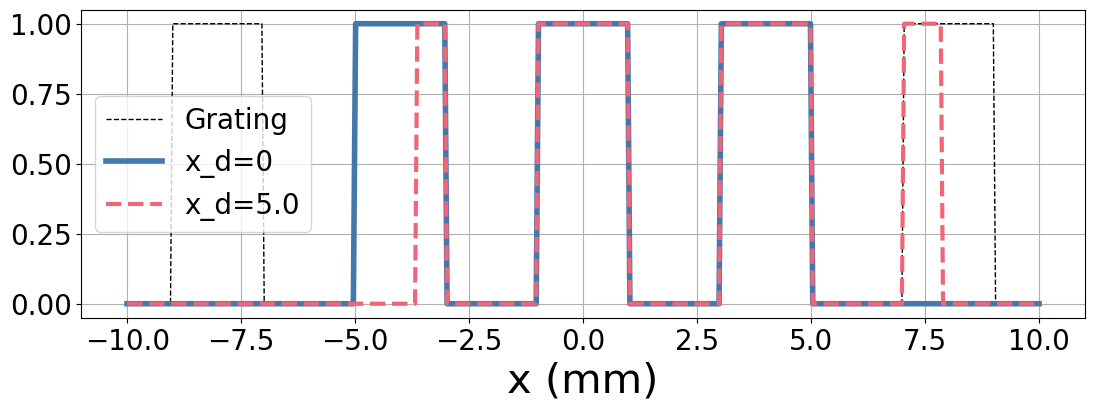

In [69]:
def grating(x,a,t,n,o):
    """Returns 1D transmission function of grating mask."""
    max_x = x[-1]
    result = np.zeros(len(x))
    for indx,i in enumerate(x):
        for s in range(1,n+1):
            if (i > (max_x - o - (a + t)*(s - 1) - t) and i < (max_x - o - (a + t)*(s - 1))):
                result[indx] = 1
    return result

def seen_grating(x,grating,xd,ls,ld,res):
    """Returns the grating as seen by point xd on the detector."""
    lower = -res/2 + (1 - ls/ld)*xd
    upper = res/2 + (1 - ls/ld)*xd
    print(f'Lower/upper limits: {round(lower,3)},{round(upper,3)}')
    mask = [i if (lower<x[indx] and x[indx]<upper) else 0 for indx,i in enumerate(grating)]
    return mask, upper, lower

x_fine = np.linspace(-slit_inner/2,slit_inner/2,400,endpoint=True)
MASK = grating(x_fine,slit_width,slit_width,slit_num,slit_offset)
SEEN,UPPER,LOWER = seen_grating(x_fine,MASK,0,Ls,Ld,Ls*ap_width/Ld)

print(f'Ls={round(Ls,2)}, Ld={round(Ld,2)}, SF={round(1-Ls/Ld,2)} R={round(res,2)} (mm)')
fig = plt.figure(figsize=(plot_width,plot_height/2))
plt.plot(x_fine,MASK,'--',label='Grating',color='black',linewidth=1)
plt.plot(x_fine,SEEN,linewidth=4,label=f'x_d=0')
xd = [det_x/2]
for x in xd:
    SEEN_xd,UPPER_xd,LOWER_xd = seen_grating(x_fine,MASK,x,Ls,Ld,Ls*ap_width/Ld) 
    plt.plot(x_fine,SEEN_xd,'--',linewidth=3,label=f'x_d={x}')
plt.xlabel('x (mm)')
plt.legend()
plt.show()

***
## Simulation scans
***

In [8]:
def do_run(ray_num,MWP1_current,MWP2_current,CG_current,sample_in=True,pols=True,plot=True,get_divs=False):
    """Performs McStas simulation of high and low count spin state.
    Returns high and low count intensities."""
    result = []
    if sample_in: sam.set_AT([sam_offset[0]*1e-3,sam_offset[1]*1e-3,Lss])
    else: sam.set_AT([1+sam_offset[0]*1e-3,sam_offset[1]*1e-3,Lss]) #one meter offset
    BCG.value = CG_current*cg_gpa  #center guide field strength (Gauss)
    AER.settings(output_path=f'{path}hc_{round(MWP1_current,2)}_{round(CG_current,2)}_{round(MWP2_current,2)}',\
                 ncount=ray_num)
    low_count.value, all_off.value, cur1.value, cur2.value = 0, 0, MWP1_current, MWP2_current
    AER_hc = AER.backengine()
    if plot: ms.make_plot(AER_hc,fontsize=5)
    if pols==False or int(MWP1_current*10)==0: #ignores low counts
        result.append(AER_hc[-1].Intensity)
    else:
        AER.settings(output_path=f'{path}lc_{round(MWP1_current,2)}_{round(CG_current,2)}_{round(MWP2_current,2)}',\
                     ncount=ray_num)
        low_count.value, all_off.value, cur1.value, cur2.value = 1, 0, MWP1_current, MWP2_current
        AER_lc = AER.backengine()
        if plot: ms.make_plot(AER_lc,fontsize=5)
        result.extend([AER_hc[-1].Intensity,AER_lc[-1].Intensity])
    if get_divs:
        result.extend(AER_hc[:-1].Intensity) #includes acceptance detectors
    return result

def do_scan(ray_num,curs1,curs2,curscg,sample_in=True,pols=True,plot=True,\
            multin=False,twoD=False,cross=False,cg=False,daisy=False):
    """Performs current scans of MWP1, CG, and/or MWP2 for given number of AER harmonics.
    Returns lists of intensities from each do_run."""
    results = []
    if multin:
        for c in curs1:
            results.extend(do_run(ray_num,c,-c,curscg,sample_in=sample_in,pols=pols,plot=plot))
    if twoD:
        for c1 in curs1:
            for c2 in curs2:
                results.extend(do_run(ray_num,c1,c2,curscg,sample_in=sample_in,pols=pols,plot=plot))
    if cross:
        for c1 in curs1:
            results.extend(do_run(ray_num,c1,c2,curscg,sample_in=sample_in,pols=pols,plot=plot))
        for c2 in curs2:
            results.extend(do_run(ray_num,c1,c2,curscg,sample_in=sample_in,pols=pols,plot=plot))
    if daisy:
        for c in curs1:
            results.extend(do_run(ray_num,c,-c,curscg,sample_in=sample_in,pols=pols,plot=plot))   
    if cg:
        for c in curscg:
            BCG.value = c*cg_gpa
            results.extend(do_run(ray_num,curs1,curs2,c,sample_in=sample_in,pols=pols,plot=plot))
        BCG.value = 0. #return center guide field to zero
    return results

### Testing Divergence detectors

In [ ]:
RAYS = 1e7 #global variables
path = 'Simulations\\div_test\\'

time_start = time.time()
div_test = do_run(RAYS,0.,0.,0.,pols=False,get_divs=True)
time_end = time.time()
print(f'Sim time: {round((time_end-time_start)/60,3)} minutes.')

In [ ]:
angles = np.linspace(-max_div,max_div,bin_ang)
labels = ['src','sam','det']

fig = plt.figure(figsize=(plot_width,plot_height/2))
plt.title('Acceptance at x=0mm')
for i in range(3):
    plt.plot(angles,div_test[i+1][:,bin_ang//2],label=labels[i],linewidth=5)
plt.xlabel('Div (deg)')
plt.legend()
plt.show()

fig = plt.figure(figsize=(plot_width,plot_height/2))
plt.title('Acceptance at x=5mm')
for i in range(3):
    plt.plot(angles,div_test[i+1][:,bin_ang-1],label=labels[i],linewidth=5)
plt.xlabel('Div (deg)')
plt.legend()
plt.show()


### Idealized current scan 1mm

In [ ]:
RAYS = 1e7 #global variables
path = 'Simulations\\1_1mm_idealized\\'

time_start = time.time()
cur_scan = do_scan(RAYS,currents,None,0.,multin=True,pols=True)
time_end = time.time()
print(f'Sim time: {round((time_end-time_start)/60,3)} minutes.')

### Realistic current scan 1mm

In [ ]:
RAYS = 1e7 #global variables
path = 'Simulations\\1_1mm_real\\'

time_start = time.time()
cur_scan = do_scan(RAYS,currents,None,0.,multin=True,pols=True)
time_end = time.time()
print(f'Sim time: {round((time_end-time_start)/60,3)} minutes.')

### Realistic current scan 2mm

In [ ]:
RAYS = 1e7 #global variables
path = 'Simulations\\2_2mm_real\\'

time_start = time.time()
cur_scan = do_scan(RAYS,currents,None,0.,multin=True,pols=True)
time_end = time.time()
print(f'Sim time: {round((time_end-time_start)/60,3)} minutes.')

### Center guide field echo scan

In [ ]:
RAYS=1e7 #global control of neutron rays
path = 'Simulations\\cg_scan\\'

Phi_for_30 = 2*np.pi*30/np.abs(1e-4*cg_gpa*CL*lam*CG_dim['z'])
CG_currents = np.linspace(Phi_for_30-.02,Phi_for_30+.02,11)
currents = CG_currents #for polarization extraction
CG_gausses = CG_currents*cg_gpa
MWP_current = get_SS_focus(harms,Ls,res,lam,MWP_parm['a'],L)[3]  #choose one with largest amplitude for 2mm
print(f'MWP current: {round(MWP_current,3)}')

dfs = np.abs(1e-4*CG_gausses*CL*lam*CG_dim['z'])%(2*np.pi)
print(f'Center guide field (G): {np.round(CG_gausses,3)}')
print(f'Larmor phase mod 2pi: {np.round(dfs,3)}')

time_start = time.time()
cur_scan = do_scan(RAYS,MWP_current,-MWP_current,CG_currents,cg=True)
time_end = time.time()
print(f'Sim time: {round((time_end-time_start)/60,3)} minutes.')

### Large wavelength spread

In [ ]:
RAYS=1e7 #global control of neutron rays
path = 'Simulations\\whitebeam\\'

time_start = time.time()
cur_scan = do_scan(RAYS,currents,None,0.,pols=True,multin=True)
time_end = time.time()
print(f'Sim time: {round((time_end-time_start)/60,3)} minutes.')

### Scanning for angle-encoding (in progress)

#### 2D scan

In [ ]:
RAYS=1e7 #global control of neutron rays
path = 'Simulations\\twoD_scan\\'

MWP_current = get_SS_focus(harms,Ls,res,lam,MWP_parm['a'],L)[3]  #choose one with largest amplitude
currents = np.linspace(MWP_current-.3,MWP_current+.3,7)
print(f'MWP currents: {np.round(currents,3)}')

time_start = time.time()
cur_scan = do_scan(RAYS,currents,-currents,0.,twoD=True,plot=False)
time_end = time.time()
print(f'Sim time: {round((time_end-time_start)/60,3)} minutes.')

In [ ]:
#need to run this cell to get the correct currents for the 2D scan
current_diffs = []

#### Cross scan

In [ ]:
RAY_NUM=1e7 #global control of neutron rays
path = 'Simulations\\ae_2d_scan\\'

MWP_current = get_SS_focus(harms,Ls,res,lam,MWP_parm['a'],L)[4]  #choose one with largest amplitude
currents = np.linspace(MWP_current-.2,MWP_current+.2,6)
print(f'MWP currents: {np.round(currents,3)}')

time_start = time.time()
cur_scan = do_2D_scan(RAY_NUM,currents,currents)
time_end = time.time()
print(f'Sim time: {round((time_end-time_start)/60,3)} minutes.')

In [ ]:
currents = np.array([np.linspace(MWP_current-.2,MWP_current+.2,6) \
                     for n in np.linspace(MWP_current-.2,MWP_current+.5,6)])
currents = np.reshape(currents,len(currents)**2)

#### Single current (daisy) scan

In [ ]:
RAYS=1e7 #global control of neutron rays
path = 'Simulations\\daisy_scan\\'

current_1 = get_SS_focus(harms,Ls,res,lam,MWP_parm['a'],L)[2]  #choose one with largest amplitude
current_2 = get_SS_focus(harms,Ls,res,lam,MWP_parm['a'],L)[4]

currents = np.linspace(current_1,current_2,25)
print(f'MWP currents: {np.round(currents,3)}')

time_start = time.time()
cur_scan = do_scan(RAYS,currents,None,0.,daisy=True)
time_end = time.time()
print(f'Sim time: {round((time_end-time_start)/60,3)} minutes.')

#### Full daisy scan

In [30]:
RAYS=1e7 #global control of neutron rays
path = 'Simulations\\full_daisy_scan\\'

current_1 = 0.
current_2 = get_SS_focus(harms,Ls,res,lam,MWP_parm['a'],L)[5]

currents = np.linspace(current_1,current_2,41)
print(f'MWP currents: {np.round(currents,3)}')

time_start = time.time()
cur_scan = do_scan(RAYS,currents,None,0.,daisy=True,plot=False,sample_in=True)
time_end = time.time()
print(f'Sim time: {round((time_end-time_start)/60,3)} minutes.')

MWP currents: [ 0.     0.254  0.509  0.763  1.017  1.272  1.526  1.78   2.035  2.289
  2.543  2.798  3.052  3.306  3.561  3.815  4.069  4.324  4.578  4.832
  5.087  5.341  5.595  5.85   6.104  6.358  6.613  6.867  7.121  7.376
  7.63   7.884  8.139  8.393  8.647  8.902  9.156  9.41   9.665  9.919
 10.173]

loading system configuration
INFO: Using directory: "C:\Users\xsm\Documents\GitHub\AER-HFIR-1-23\Simulations\full_daisy_scan\hc_0.0_0.0_-0.0"
INFO: Regenerating c-file: AER_HFIR_2023.c

-----------------------------------------------------------

Generating single GPU kernel or single CPU section layout: 

-----------------------------------------------------------

Generating GPU/CPU -DFUNNEL layout:

-----------------------------------------------------------
Info:    'Source_sam' is a contributed component.
Info:    'Pol_MWP_v3' is a contributed component.
Info:    'grating_mask' is a contributed component.
CFLAGS=
INFO: Recompiling: AER_HFIR_2023.exe
AER_HFIR_2023.c: In function 

#### Daisy empty scan

In [46]:
RAYS=1e7 #global control of neutron rays
path = 'Simulations\\empty_daisy_scan\\'

empty_current_1 = 0.
empty_current_2 = get_SS_focus(harms,Ls,res,lam,MWP_parm['a'],L)[5]

empty_currents = np.linspace(empty_current_1,empty_current_2,41)
print(f'MWP currents: {np.round(empty_currents,3)}')

time_start = time.time()
empty_cur_scan = do_scan(RAYS,empty_currents,None,0.,daisy=True,plot=False,sample_in=False)
time_end = time.time()
print(f'Sim time: {round((time_end-time_start)/60,3)} minutes.')

MWP currents: [ 0.     0.254  0.509  0.763  1.017  1.272  1.526  1.78   2.035  2.289
  2.543  2.798  3.052  3.306  3.561  3.815  4.069  4.324  4.578  4.832
  5.087  5.341  5.595  5.85   6.104  6.358  6.613  6.867  7.121  7.376
  7.63   7.884  8.139  8.393  8.647  8.902  9.156  9.41   9.665  9.919
 10.173]

loading system configuration
INFO: Using directory: "C:\Users\xsm\Documents\GitHub\AER-HFIR-1-23\Simulations\empty_daisy_scan\hc_0.0_0.0_-0.0"
INFO: Regenerating c-file: AER_HFIR_2023.c

-----------------------------------------------------------

Generating single GPU kernel or single CPU section layout: 

-----------------------------------------------------------

Generating GPU/CPU -DFUNNEL layout:

-----------------------------------------------------------
Info:    'Source_sam' is a contributed component.
Info:    'Pol_MWP_v3' is a contributed component.
Info:    'grating_mask' is a contributed component.
CFLAGS=
INFO: Recompiling: AER_HFIR_2023.exe
AER_HFIR_2023.c: In function

***
## Data Analysis
***

### Data Loader (legacy: before 3/17/2023)

In [ ]:
path = 'C:\\Users\\xsm\\Documents\\GitHub\\AER-HFIR-1-23\\Simulations\\'
sim_folder = 'Ideal_cur_scan_1e8\\'

def data_loader(dirs,sort=True,plot=False,N0=True,curscan_format=True):
    """Loads data into tuple of titles and 2D intensities in curscan format."""
    data,counts,curs = [],[],[]
    output_data,titles = [],[]
    for d in islice(os.walk(dirs),1,None):
        lc = d[0].split('\\')[-1][:2]
        cu = d[0].split('\\')[-1][2:]
        counts.append(lc)
        curs.append(float(cu))
        data.append(ms.load_data(d[0])[0].Intensity)
    temp = zip(curs,counts,data)
    if sort: temp = sorted(temp)  #sorts by current, then hc first lc second
    else: temp = list(temp)
    if curscan_format:  #pairs high counts and low counts
        if N0:
            output_data.append([temp[0][2],np.zeros(np.shape(temp[0][2]))])
            titles.append([temp[0][1]+str(temp[0][0]),'---'])
            for k in range(len(temp)//2): 
                output_data.append([temp[2*k+1][2],temp[2*k+2][2]])
                titles.append([temp[2*k+1][1]+str(temp[2*k+1][0]),temp[2*k+2][1]+str(temp[2*k+2][0])])
        else:
            for k in range(len(temp)//2):
                output_data.append([temp[2*k][2],temp[2*k+1][2]])
                titles.append([temp[2*k][1]+str(temp[2*k][0]),temp[2*k+1][1]+str(temp[2*k+1][0])])
        if plot:
            for indx,data in enumerate(output_data):
                fig,axs = plt.subplots(1,2,figsize=(plot_width,plot_height))
                axs[0].set_title(titles[indx][0])
                im1 = axs[0].imshow(data[0],origin='lower')
                axs[1].set_title(titles[indx][1])
                im2 = axs[1].imshow(data[1],origin='lower')
                plt.colorbar(im1,ax=axs[0])
                plt.colorbar(im2,ax=axs[1])
                plt.show()
    else:  #format for normalized intensities
        for k in range(len(temp)):
            output_data.append(temp[k][2])
            titles.append(temp[k][1]+str(temp[k][0]))
        if plot:
            for indx,data in enumerate(output_data):
                fig = plt.figure(figsize=(plot_width,plot_height))
                plt.title(titles[indx])
                plt.imshow(data,origin='lower')
                plt.colorbar()
                plt.show()
    
    return titles,output_data

ts,cur_scan = data_loader(path+sim_folder,curscan_format=True,plot=False)
currents = []
for indx,i in enumerate(ts):
    currents.append(float(i[0][2:]))
print(currents)

Need to worry about getting currents from scan, detector size, and other simualtion parameters into the data loader. Works fine for right now, but that will change as soon as I start to compare the signals from slightly different McStas beamlines.

### Data Loader (to do)

In [ ]:
path = 'C:\\Users\\xsm\\Documents\\GitHub\\AER-HFIR-1-23\\Simulations\\'
sim_folder = 'full_daisy_scan\\'

def data_loader(dirs,sort=True,plot=False,N0=True,curscan_format=True):
    """Loads data into tuple of titles and 2D intensities in curscan format."""
    data,counts,curs = [],[],[]
    output_data,titles = [],[]
    for d in islice(os.walk(dirs),1,None):
        lc = d[0].split('\\')[-1][:2]
        cu = d[0].split('\\')[-1][2:]
        counts.append(lc)
        curs.append(float(cu))
        data.append(ms.load_data(d[0])[0].Intensity)
    temp = zip(curs,counts,data)
    if sort: temp = sorted(temp)  #sorts by current, then hc first lc second
    else: temp = list(temp)
    if curscan_format:  #pairs high counts and low counts
        if N0:
            output_data.append([temp[0][2],np.zeros(np.shape(temp[0][2]))])
            titles.append([temp[0][1]+str(temp[0][0]),'---'])
            for k in range(len(temp)//2): 
                output_data.append([temp[2*k+1][2],temp[2*k+2][2]])
                titles.append([temp[2*k+1][1]+str(temp[2*k+1][0]),temp[2*k+2][1]+str(temp[2*k+2][0])])
        else:
            for k in range(len(temp)//2):
                output_data.append([temp[2*k][2],temp[2*k+1][2]])
                titles.append([temp[2*k][1]+str(temp[2*k][0]),temp[2*k+1][1]+str(temp[2*k+1][0])])
        if plot:
            for indx,data in enumerate(output_data):
                fig,axs = plt.subplots(1,2,figsize=(plot_width,plot_height))
                axs[0].set_title(titles[indx][0])
                im1 = axs[0].imshow(data[0],origin='lower')
                axs[1].set_title(titles[indx][1])
                im2 = axs[1].imshow(data[1],origin='lower')
                plt.colorbar(im1,ax=axs[0])
                plt.colorbar(im2,ax=axs[1])
                plt.show()
    else:  #format for normalized intensities
        for k in range(len(temp)):
            output_data.append(temp[k][2])
            titles.append(temp[k][1]+str(temp[k][0]))
        if plot:
            for indx,data in enumerate(output_data):
                fig = plt.figure(figsize=(plot_width,plot_height))
                plt.title(titles[indx])
                plt.imshow(data,origin='lower')
                plt.colorbar()
                plt.show()
    
    return titles,output_data

ts,cur_scan = data_loader(path+sim_folder,curscan_format=True,plot=False)
currents = []
for indx,i in enumerate(ts):
    currents.append(float(i[0][2:]))
print(currents)

***
### Polarization Extraction
***

In [73]:
def get_pol(h,l):
    """Returns 2D polarization from current scans."""
    pol = np.zeros(np.shape(h))
    for indx,val in np.ndenumerate(pol):
        psum = h[indx[0],indx[1]] + l[indx[0],indx[1]]
        if psum != 0:
            pol[indx[0],indx[1]] = (h[indx[0],indx[1]] - l[indx[0],indx[1]])/psum
    return pol

ignore_first = True
if ignore_first:
    highs = np.array(cur_scan[1::2]) #removes zero-current scan
    lows = np.array(cur_scan[2::2])
    pols = [get_pol(highs[i],lows[i]) for i in range(0,(len(cur_scan)-1)//2)]
    pol_labels = np.round(currents[1:],2)
else:
    highs = np.array(cur_scan[::2]) #includes zeroth scan in polarizations
    lows = np.array(cur_scan[1::2])
    pols = [get_pol(highs[i],lows[i]) for i in range(0,len(cur_scan)//2)]
    pol_labels = np.round(currents,2)
    
do_rebin = False
if do_rebin:
    rebin_size = (50,50)
    print(f'New bin size: {round(det_x/rebin_size[0],3)} (mm)')

print(f'Currents used: {np.round(currents,2)} \n')

plot_pols,plot_all_slices,plot_slices = False,False,False
if plot_pols:
    for indx,p in enumerate(pols):
        fig = plt.figure(figsize=(plot_width,plot_height))
        plt.title(f'Harm. {indx+1}, {pol_labels[indx]} amps')
        plt.tight_layout()
        if do_rebin: p=rebin(p,rebin_size)
        plt.imshow(p,origin='lower',extent=[-det_x/2,det_x/2,-det_y/2,det_y/2],interpolation='none')
        plt.ylabel('y (mm)')
        plt.xlabel('x (mm)')
        plt.colorbar()
        plt.show()
if plot_all_slices:
    fig = plt.figure(figsize=(plot_width,plot_height))
    x = np.linspace(-det_x/2,det_x/2,bin_x)
    for indx,p in enumerate(pols):
        if do_rebin:
            p = rebin(p,rebin_size)
            x = np.linspace(-det_x/2,det_x/2,rebin_size[0])
        plt.plot(x,np.mean(p,axis=0),'.-',ms=15,label=f'{pol_labels[indx]}')
    plt.ylabel('Pol')
    plt.xlabel('x (mm)')
    plt.legend()
    plt.show()
if plot_slices:
    x = np.linspace(-det_x/2,det_x/2,bin_x)
    for indx,p in enumerate(pols):
        fig = plt.figure(figsize=(plot_width,plot_height))
        if do_rebin:
            p = rebin(p,rebin_size)
            x = np.linspace(-det_x/2,det_x/2,rebin_size[0])
        plt.plot(x,np.mean(p,axis=0),'.-',ms=15,label=f'{pol_labels[indx]}',color=f'C{indx}')
        plt.ylabel('Pol')
        plt.xlabel('x (mm)')
        plt.legend()
        plt.show()

Currents used: [ 0.    0.25  0.51  0.76  1.02  1.27  1.53  1.78  2.03  2.29  2.54  2.8
  3.05  3.31  3.56  3.82  4.07  4.32  4.58  4.83  5.09  5.34  5.6   5.85
  6.1   6.36  6.61  6.87  7.12  7.38  7.63  7.88  8.14  8.39  8.65  8.9
  9.16  9.41  9.66  9.92 10.17] 



##### Empty beam analysis (daisy compatible)

A = 0.26817
Normalization = 1.68499


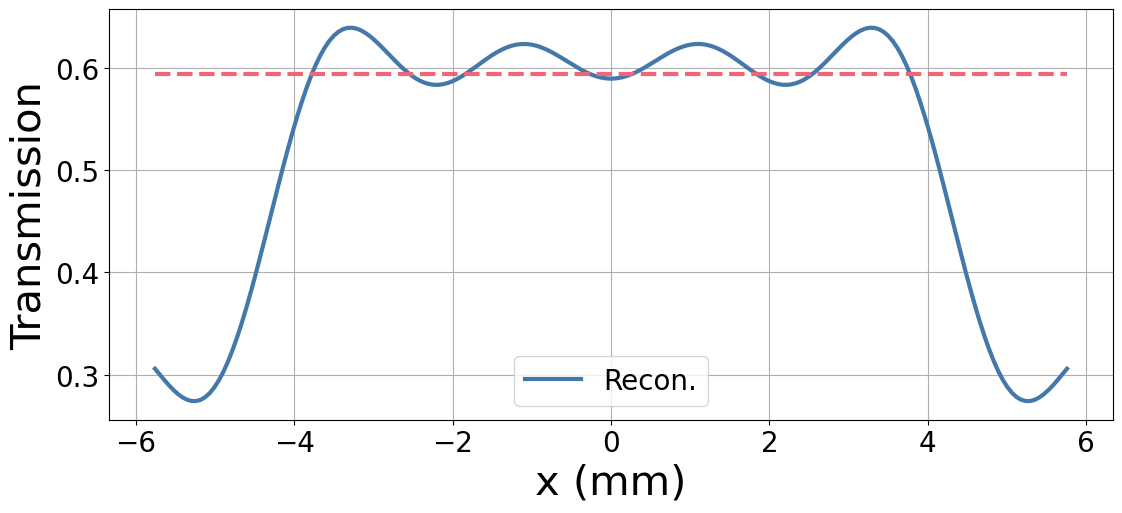

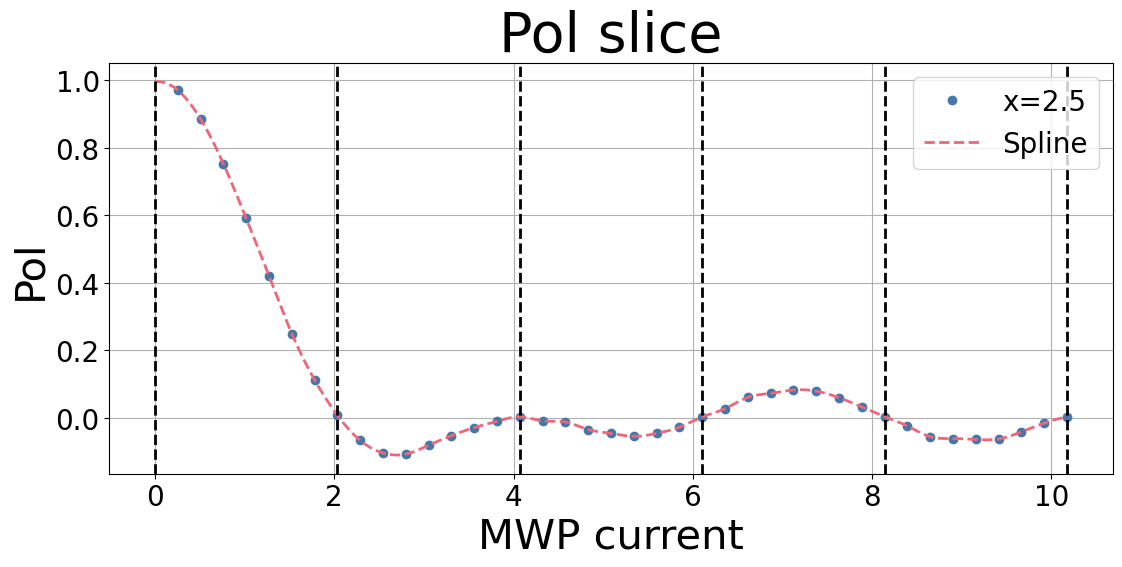

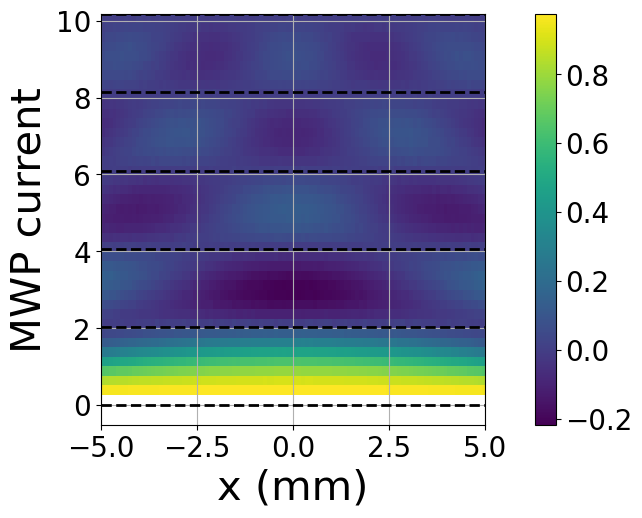

In [284]:
empty_fine_currents = np.linspace(empty_currents[0],empty_currents[-1],200)
x = np.linspace(-res/2,res/2,200)
x_data = np.linspace(-det_x/2,det_x/2,bin_x)

A = CL*lam*strength*2*(L2-L1)/Ls*1e-3  #x is in mm
print(f'A = {round(A,5)}')
norml = 2*np.pi*A
print(f'Normalization = {round(norml,5)}')

ignore_first = True
if ignore_first:
    empty_highs = np.array(empty_cur_scan[1::2])
    empty_lows = np.array(empty_cur_scan[2::2])
    empty_pols = [get_pol(empty_highs[i],empty_lows[i]) for i in range(0,(len(empty_cur_scan)-1)//2)]
else:
    empty_highs = np.array(empty_cur_scan[::2])
    empty_lows = np.array(empty_cur_scan[1::2])
    empty_pols = [get_pol(empty_highs[i],empty_lows[i]) for i in range(0,len(empty_cur_scan)//2)]

empty_slice_pos = []
empty_all_currs = []
empty_slice_val = 2.5
empty_slice_indx = np.argmin(np.abs(x_data - empty_slice_val))
for p in empty_pols:
    empty_slice_pos.append(np.mean(p,axis=0)[empty_slice_indx])
    empty_all_currs.append(np.mean(p,axis=0))

empty_fitted_p = CubicSpline(empty_currents[1:],empty_slice_pos)(empty_fine_currents)

fig = plt.figure(figsize=(plot_width,plot_height/1.5))
empty_ft_inv = []
for xi in x+empty_slice_val:
    empty_ft_inv.append(1/norml*simpson(empty_fitted_p*np.cos(A*empty_fine_currents*(xi-empty_slice_val)),\
                                        empty_fine_currents))
plt.plot(x,empty_ft_inv,linewidth=3,label='Recon.')
plt.plot(x,np.ones(len(x))/norml,'--',linewidth=3)
plt.ylabel('Transmission')
plt.xlabel('x (mm)')
plt.legend()
plt.show()

fig = plt.figure(figsize=(plot_width,plot_height/1.5))
plt.title('Pol slice')
plt.plot(empty_currents[1:],empty_slice_pos,'o',label=f'x={round(slice_val,2)}')
plt.plot(empty_fine_currents,empty_fitted_p,'--',linewidth=2,label='Spline')
for c in get_SS_focus(harms,Ls,res,lam,MWP_parm['a'],L)[:6]:
    plt.axvline(x=c,linestyle='--',color='black',linewidth=2)
plt.ylabel('Pol')
plt.xlabel('MWP current')
plt.legend()
plt.show()

fig = plt.figure(figsize=(plot_width,plot_height/1.5))
plt.imshow(empty_all_currs,extent=[-det_x/2,det_x/2,empty_currents[1],empty_currents[-1]],origin='lower')
for c in get_SS_focus(harms,Ls,res,lam,MWP_parm['a'],L)[:6]:
    plt.axhline(y=c,linestyle='--',color='black',linewidth=2)
plt.ylabel('MWP current')
plt.xlabel('x (mm)')
plt.colorbar()
plt.show()

##### Daisy scan analysis

A = 0.26817
Normalization = 1.68499
Lower/upper limits: -4.697,6.818


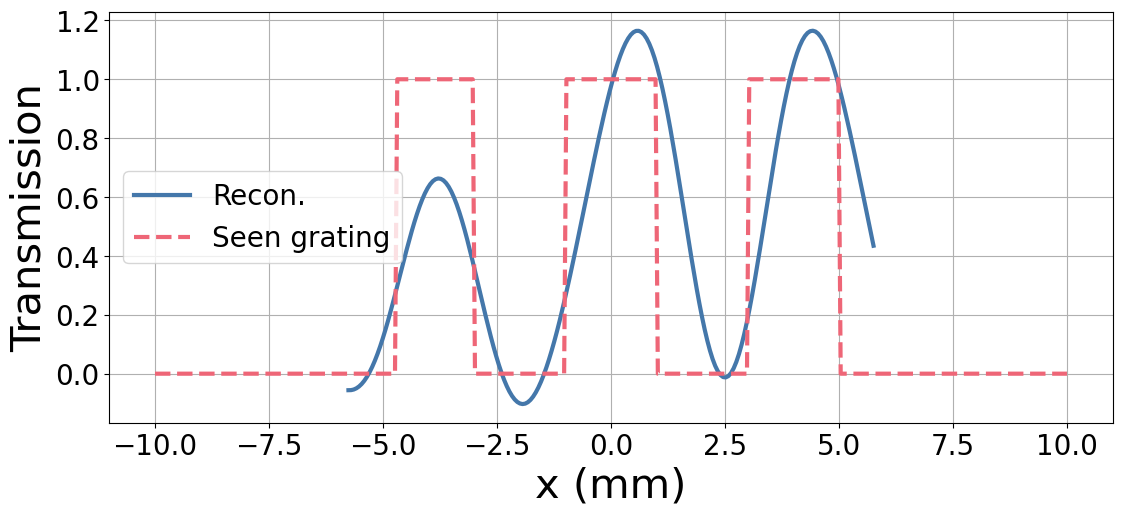

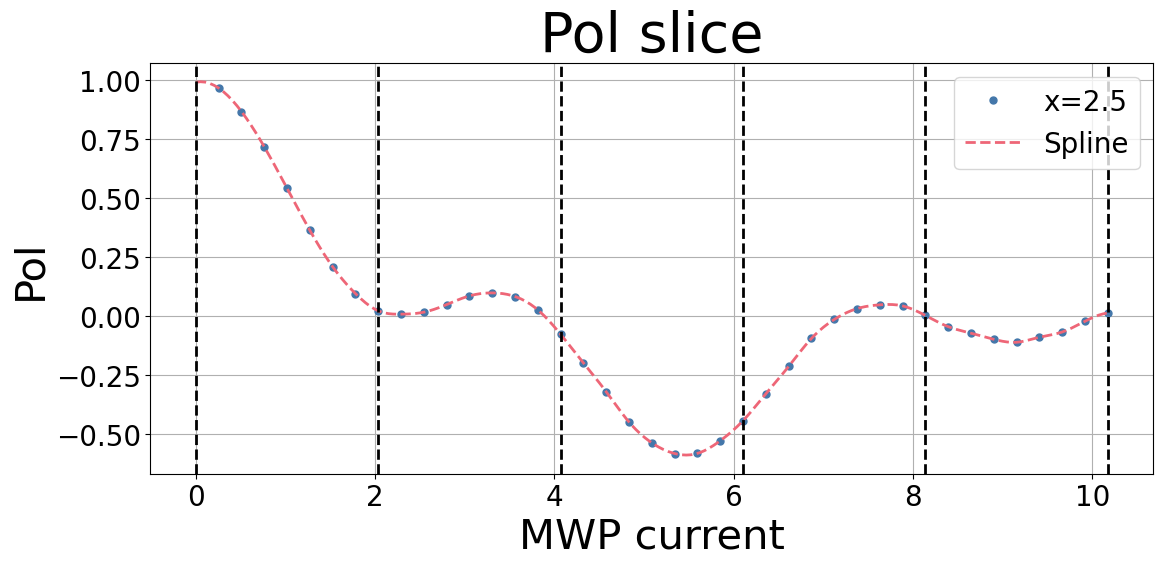

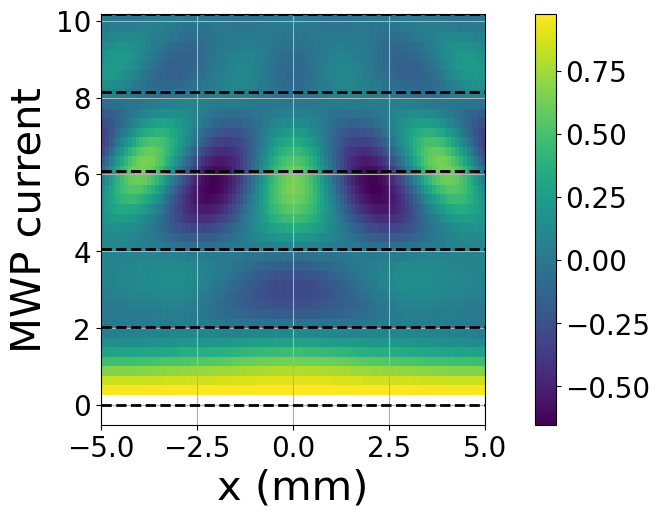

In [283]:
fine_currents = np.linspace(currents[0],currents[-1],200)
x = np.linspace(-res/2,res/2,200)
x_data = np.linspace(-det_x/2,det_x/2,bin_x)

A = CL*lam*strength*2*(L2-L1)/Ls*1e-3  #x is in mm
print(f'A = {round(A,5)}')
norml = 2*np.pi*A
print(f'Normalization = {round(norml,5)}')

slice_pos = []
all_currs = []
slice_val = 2.5
slice_indx = np.argmin(np.abs(x_data - slice_val))
for p in pols:
    slice_pos.append(np.mean(p,axis=0)[slice_indx])
    all_currs.append(np.mean(p,axis=0))

fitted_p = CubicSpline(currents[1:],slice_pos)(fine_currents)

fig = plt.figure(figsize=(plot_width,plot_height/1.5))
ft_inv = []
for xi in x:
    ft_inv.append(1/norml*simpson(fitted_p*np.cos(A*fine_currents*(xi-slice_val)),fine_currents))
plt.plot(x,ft_inv,linewidth=3,label='Recon.')

x_fine = np.linspace(-slit_inner/2,slit_inner/2,400,endpoint=True)
MASK = grating(x_fine,slit_width,slit_width,slit_num,slit_offset)
SEEN,_,_ = seen_grating(x_fine,MASK,slice_val,Ls,Ld,Ls*ap_width/Ld)
plt.plot(x_fine,SEEN,'--',linewidth=3,label='Seen grating')

plt.legend()
plt.ylabel('Transmission')
plt.xlabel('x (mm)')
plt.show()

fig = plt.figure(figsize=(plot_width,plot_height/1.5))
plt.title('Pol slice')
plt.plot(currents[1:],slice_pos,'o',ms=5,label=f'x={round(slice_val,2)}')
plt.plot(fine_currents, fitted_p,'--',linewidth=2,label='Spline')
for c in get_SS_focus(harms,Ls,res,lam,MWP_parm['a'],L)[:6]:
    plt.axvline(x=c,linestyle='--',color='black',linewidth=2)
plt.ylabel('Pol')
plt.xlabel('MWP current')
plt.legend()
plt.show()

fig = plt.figure(figsize=(plot_width,plot_height/1.5))
plt.imshow(all_currs,extent=[-det_x/2,det_x/2,currents[1],currents[-1]],origin='lower')
for c in get_SS_focus(harms,Ls,res,lam,MWP_parm['a'],L)[:6]:
    plt.axhline(y=c,linestyle='--',color='black',linewidth=2)
plt.ylabel('MWP current')
plt.xlabel('x (mm)')
plt.colorbar()
plt.show()

Peaks found: [0.10224469 3.01621827 7.92396324 8.63967605 9.50875589]
Troughs found: [1.22693624 5.5212131  8.43518668 9.09977714 9.61100058]


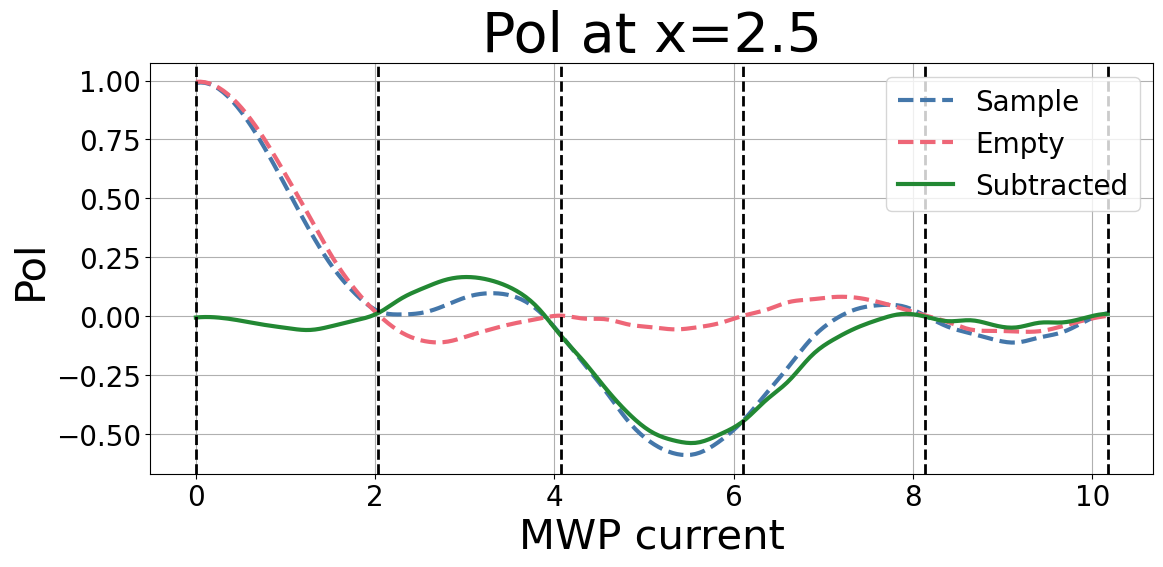

In [285]:
fig = plt.figure(figsize=(plot_width,plot_height/1.5))
plt.title(f'Pol at x={slice_val}')
plt.plot(fine_currents,fitted_p,'--',label='Sample',linewidth=3)
plt.plot(empty_fine_currents,empty_fitted_p,'--',label='Empty',linewidth=3)
if len(empty_fine_currents)==len(fine_currents):
    subtracted = fitted_p - empty_fitted_p
    plt.plot(fine_currents,subtracted,label='Subtracted',linewidth=3)
    pks,_ = find_peaks(subtracted,threshold=0)
    trs,_ = find_peaks(-subtracted,threshold=0)
    print(f'Peaks found: {fine_currents[pks]}')
    print(f'Troughs found: {fine_currents[trs]}')
for c in get_SS_focus(harms,Ls,res,lam,MWP_parm['a'],L)[:6]:
    plt.axvline(x=c,linestyle='--',color='black',linewidth=2)
plt.ylabel('Pol')
plt.xlabel('MWP current')
plt.legend()
plt.show()

##### Center guide field scan analysis

In [ ]:
def cg_cos(x,a,per,p):
    return a*np.cos(x*2*np.pi/per + p)
fine_currents = np.linspace(currents[1],currents[-1],200)

centers = []
for indx,p in enumerate(pols):
    centers.append(np.mean(p,axis=0)[50])
lwb, upb = [.3,0,-3.14], [.7,.05,3.14]
parms,_ = curve_fit(cg_cos,currents[1:],centers,p0=[.5,.033,0],bounds=[lwb,upb])
print(f'[amp,per,phase]: {np.round(parms,5)}')
    
plt.title('Pol at x=0')
plt.plot(currents[1:],centers,'o')
plt.plot(fine_currents,cg_cos(fine_currents,*parms))
plt.ylabel('Pol')
plt.xlabel('Center guide current')
plt.show()

Polarization seems to take a hit even with the low wavelegth spread of CG-4B when we turn on the guide field. Hopefully this can be corrected/accounted for for the reconstruction.

### Normed Intensity Extractor (to fix)

In [ ]:
def get_ni(data,zeroth):
    """Returns 2D N_0 normalized intensity from current scans."""
    nint = np.zeros(np.shape(data[0]))
    for indx,val in np.ndenumerate(nint):
        if zeroth[indx[0],indx[1]] != 0:
            nint[indx[0],indx[1]] = data[0,indx[0],indx[1]]/zeroth[indx[0],indx[1]]
    return nint
nints = [get_ni(np.array(cur_scan[i]),np.array(cur_scan[0])) for i in range(1,len(cur_scan)//2-1,2)]
print(f'Currents used: {np.round(currents,2)} \n')

plot_nints,plot_slices,plot_all_slices = False,True,True

do_rebin = False
rebin_size = (50,50)
if do_rebin: print(f'New bin size: {round(det_x/rebin_size[0],3)} (mm)')

if plot_nints:
    for indx,n in enumerate(nints):
        fig = plt.figure(figsize=(plot_width,plot_height))
        plt.title(f'Harm. {indx+1}, {round(currents[indx+1],2)} amps')
        plt.tight_layout()
        if do_rebin: n=rebin(p,rebin_size)
        plt.imshow(n,origin='lower',extent=[-det_x/2,det_x/2,-det_y/2,det_y/2],interpolation='none')
        plt.ylabel('y (mm)')
        plt.xlabel('x (mm)')
        plt.colorbar()
        plt.show()

if plot_all_slices:
    fig = plt.figure(figsize=(plot_width,plot_height))
    x = np.linspace(-det_x/2,det_x/2,bin_x)
    for indx,n in enumerate(nints):
        if do_rebin:
            n = rebin(n,rebin_size)
            x = np.linspace(-det_x/2,det_x/2,rebin_size[0])
        plt.plot(x,np.mean(n,axis=0),'.-',ms=15,label=f'{round(currents[indx+1],2)}')
    plt.ylabel('Norm I')
    plt.xlabel('x (mm)')
    plt.legend()
    plt.show()

if plot_slices:
    x = np.linspace(-det_x/2,det_x/2,bin_x)
    for indx,n in enumerate(nints):
        fig = plt.figure(figsize=(plot_width,plot_height))
        if do_rebin:
            n = rebin(n,rebin_size)
            x = np.linspace(-det_x/2,det_x/2,rebin_size[0])
        plt.plot(x,np.mean(n,axis=0),'.-',ms=15,label=f'{round(currents[indx+1],2)},{indx+1}',color=f'C{indx}')
        envelope = np.mean(n,axis=0)/np.abs(hilbert(np.mean(n,axis=0)))
        #plt.plot(x,envelope,'--',color=f'C{indx}')
        #plt.plot(x,-envelope,'--',color=f'C{indx}')
        plt.ylabel('Norm I')
        plt.xlabel('x (mm)')
        plt.legend()
        plt.show()

***
## Analytical and Simulated Reconstruction Comparison
***

In [ ]:
x = np.linspace(-det_x/2,det_x/2,bin_x)
x_mid = x[len(p)//2-4:len(p)//2+4]
x_fine = np.linspace(-det_x/2,det_x/2,200)
fits,errs,guess = [[] for i in range(len(pols))],[[] for i in range(len(pols))],[[] for i in range(len(pols))]
peak_fits,peak_errs,peak_guess = [[] for i in range(len(pols))],[[] for i in range(len(pols))],[[] for i in range(len(pols))]

def fit_pols(pols,plot_fits=True,plot_peaks=True):
    for i,_ in enumerate(pols):
        p = np.mean(pols[i],axis=0)
        guess[i] = np.array([p[len(p)//2],.0,2*np.pi*(i + 1)/res])
        #guess[i] = np.array([p[len(p)//2],2*np.pi*(i + 2)/res,0])
        peak_guess[i] = [-1.,0,p[len(p)//2]]
        p_mid = p[len(p)//2-4:len(p)//2+4]
        fits[i],errs[i] = curve_fit(pol_sc,x,p,p0=guess[i])
        peak_fits[i],peak_errs[i] = curve_fit(quad,x_mid,p_mid,p0=guess[i])
        
        if plot_fits:
            fig = plt.figure(figsize=(plot_width,plot_height))
            plt.title(f'Harm. {i+1}, {round(currents[i+1],2)} amps')
            plt.plot(x,np.mean(pols[i],axis=0),'.',color='C0')
            plt.plot(x,pol_sc(x,*fits[i]),color='C0',label='Fit')
            plt.plot(x,pol_sc(x,*guess[i]),color='C1',label='Guess')
            plt.legend()
            plt.show()
        if plot_peaks:
            fig = plt.figure(figsize=(plot_width,plot_height))
            plt.title(f'Harm. {i+1}, {round(currents[i+1],2)} amps')
            plt.plot(x,np.mean(pols[i],axis=0),'.',color='C0')
            plt.plot(x_mid,quad(x_mid,*peak_fits[i]),color='C0',label='Quad Fit')
            print(f'Const={round(peak_fits[i][2],2)}, Lin={round(peak_fits[i][1],2)}')
            plt.legend()
            plt.show()

def sum_series(x,R,an,bn,nl,nu,a0=1,norm=True):
    """Sums Fourier series from coefficients."""
    assert(len(an) == len(bn)), "Too many an's or bn's!"
    cn = np.array([np.cos(2*np.pi*(i+1)*x/R) for i in range(nl,nu)])
    sn = np.array([np.sin(2*np.pi*(i+1)*x/R) for i in range(nl,nu)])
    tot = a0 + 2*(np.dot(an,cn) + np.dot(bn,sn))
    if norm: tot = tot/simpson(tot,x) #divide by resolution, because a0 = 1/res
    return tot

def get_coeff(x,f,n,R,print_coeff=True):
    """Returns Fourier cosine or sine coefficient."""
    an = simpson(f*np.cos(2*np.pi*n/R*x),x)
    bn = simpson(f*np.sin(2*np.pi*n/R*x),x)
    if print_coeff: print(f'\t a{n} = {round(an,5)}, b{n} = {round(bn,5)}')
    return an,bn

def get_ana(x,f,nl,nu,R,a0=1,norm=True,print_coeff=False):
    """Returns Fourier series up to order n. a0 is given."""
    an,bn = np.zeros(nu-nl),np.zeros(nu-nl)
    if print_coeff: print(f'Analytic Fourier coefficients:')
    for indx,n in enumerate(range(nl,nu)):
        an[indx],bn[indx] = get_coeff(x,f,n+1,R,print_coeff=print_coeff)
    return sum_series(x,R,an,bn,nl,nu,a0=a0,norm=norm), an, bn

def get_N0(x,f,R,norm=True):
    """Returns traditional normalized radiograph (n=0)."""
    return 1/res*simpson(f,x)
    
fit_pols(pols,plot_fits=False,plot_peaks=False)
peak_fits = np.array(peak_fits)
print('Simulated Fourier coefficients:')
for n in range(len(peak_fits[:,2])):
    print(f'\t a{n+1} = {round(peak_fits[n,2],5)}, b{n+1} = {round(peak_fits[n,1],5)}')
    
res_fine = np.linspace(-res/2,res/2,200)

coarse_mask = grating(res_fine,2,2,5,.75)  #magic number for offset
coarse_mask = coarse_mask/simpson(coarse_mask,res_fine)

images = [sum_series(res_fine,res,peak_fits[:i,2],peak_fits[:i,1],0,i) for i in harms[1:]]
anas = [get_ana(res_fine,coarse_mask,0,i,res)[0] for i in harms[1:-1]] + \
        [get_ana(res_fine,coarse_mask,0,harms[-1],res)[0]]
ana_coeffs = get_ana(res_fine,coarse_mask,0,len(harms)-1,res,print_coeff=True)[1:]

N0 = np.mean(cur_scan[0],axis=0)/simpson(np.mean(cur_scan[0],axis=0),x)

plot_ps,plot_comps = True,False

for i in harms[:-1]:
    if plot_ps:
        fig = plt.figure(figsize=(plot_width,plot_height))
        plt.title(f'Sum up to harmonic {i+1}')
        plt.plot(res_fine,images[i],linewidth=4,label='Simulated')
        plt.plot(res_fine,anas[i],linewidth=4,label='Analytic')
        plt.plot(res_fine,coarse_mask,linewidth=4,label='T(x)')
        plt.plot(x,N0,linewidth=4,label='N_0')
        plt.legend()
        plt.show()
    
    if plot_comps:
        fig = plt.figure(figsize=(plot_width,plot_height))
        plt.title(f'Only harmonic {i+1}')
        temp_sim = sum_series(res_fine,res,[peak_fits[i,2]],[peak_fits[i,1]],i,i+1)
        temp_ana = get_ana(res_fine,coarse_mask,i,i+1,res)[0]
        plt.plot(res_fine,temp_sim,linewidth=4,label='Simulated')
        plt.plot(res_fine,temp_ana,linewidth=4,label='Analytic')
        plt.plot(res_fine,coarse_mask,linewidth=4,label='T(x)')
        plt.plot(x,N0,linewidth=4,label='N_0')
        plt.legend()
        plt.show()

***
## Solution animations
***

In [ ]:
def AER_ani(frame):
    frame += 2
    temp_cos_vals_num = 2*np.array([simple_cos(xpos_finer, *nic_hc_fits[i])[500] for i in range(0,frame)]) - 1
    temp_cos_vals_num = np.insert(temp_cos_vals_num, 0, 1/2, axis=0)
    temp_recon_num = np.asarray([temp_cos_vals_num[0] + np.sum(np.array([temp_cos_vals_num[i]*np.cos(2*np.pi*i/res*x) \
                                for i in range(1,frame)]), axis=0) for x in xpos_finer])
    temp_recon_num = temp_recon_num/np.sum(temp_recon_num)
    ax.set_title(r'Reconstruction up to $N ='+str(frame-1)+'$')
    line.set_ydata(temp_recon_num)
    line.set_label(r'$N=$'+str(frame-1))
    plt.text(-1.6, 5e-3, r'$R_{\mathrm{AER}}=\num{'+str(round(res/frame,2))+r'}\unit{\milli \meter}$', \
             fontdict=dict(fontsize=60), bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=.25'))
    plt.legend()
    
fig = plt.figure(figsize=(plot_width,plot_height))
ax = plt.axes()
ax.plot(xpos_finer, slit_T(xpos_finer, slit_x*1e-3)/np.sum(slit_T(xpos_finer, slit_x*1e-3)), linewidth=8, label='$T(x)$')
line, = ax.plot(xpos_finer, np.zeros(len(xpos_finer)), linewidth=8)
#ax.plot(xpos_finer, np.zeros(len(xpos_finer)), '-', linewidth=5, label='Num. Recon')
#plt.plot(xpos_finer, recon_num/np.sum(recon_num), '--', linewidth=5, label='Num. Recon')
#plt.text(-1.6, 7.75e-3, r'Slit width = $\num{200}\unit{\micro \meter}$', \
#         bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=.25'))
ax.set_ylim(-.002, .010)
plt.xlabel('x ' + r'$[\unit{\milli \meter}]$')
plt.ylabel('Transmission')
plt.legend()
plt.grid('on')

F_tot = 6
F_int = 200
FPS = .5
anim = FuncAnimation(fig, AER_ani, frames=F_tot, interval=F_int, repeat=False)
anim.save('Aer_soln_FPS'+str(FPS)+'_frames'+str(F_tot)+'.gif', writer='pillow', fps=FPS)
plt.close()
print('Ding!')


In [ ]:
def AER_ani(frame):
    frame += 7
    temp_cos_vals_num = 2*np.array([simple_cos(xpos_finer, *nic_hc_fits[i])[500] for i in range(0,frame)]) - 1
    temp_cos_vals_num = np.insert(temp_cos_vals_num, 0, 1/2, axis=0)
    temp_recon_num = np.asarray([temp_cos_vals_num[0] + np.sum(np.array([temp_cos_vals_num[i]*np.cos(2*np.pi*i/res*x) \
                                for i in range(1,frame)]), axis=0) for x in xpos_finer])
    temp_recon_num = temp_recon_num/np.sum(temp_recon_num)
    ax.set_title(r'Reconstruction up to $N ='+str(frame-1)+'$')
    line.set_ydata(temp_recon_num)
    line.set_label(r'$N=$'+str(frame-1))
    plt.text(-1.6, 5e-3, r'$R_{\mathrm{AER}}=\num{'+f"{round(res/frame,2):.2f}"+r'}\unit{\milli \meter}$', \
             fontdict=dict(fontsize=60), bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=.25'))
    plt.legend()
    
fig = plt.figure(figsize=(plot_width,plot_height))
ax = plt.axes()
ax.plot(xpos_finer, slit_T(xpos_finer, slit_x*1e-3)/np.sum(slit_T(xpos_finer, slit_x*1e-3)), linewidth=8, label='$T(x)$')
line, = ax.plot(xpos_finer, np.zeros(len(xpos_finer)), linewidth=8)
#ax.plot(xpos_finer, np.zeros(len(xpos_finer)), '-', linewidth=5, label='Num. Recon')
#plt.plot(xpos_finer, recon_num/np.sum(recon_num), '--', linewidth=5, label='Num. Recon')
#plt.text(-1.6, 7.75e-3, r'Slit width = $\num{200}\unit{\micro \meter}$', \
#         bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=.25'))
ax.set_ylim(-.002, .011)
plt.xlabel('x ' + r'$[\unit{\milli \meter}]$')
plt.ylabel('Transmission')
plt.legend()
plt.grid('on')

F_tot = 10
F_int = 200
FPS = .5
anim = FuncAnimation(fig, AER_ani, frames=F_tot, interval=F_int, repeat=False)
anim.save('Aer_soln_higher_FPS'+str(FPS)+'_frames'+str(F_tot)+'.gif', writer='pillow', fps=FPS)
plt.close()
print('Ding!')
